In [ ]:
import numpy as np 
import os
from tqdm import tqdm
import random
import skimage.io as io
from skimage.io import imread, imshow
import skimage.transform as trans
from skimage.transform import resize
import numpy as np
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras import backend as keras
#from tensorflow import keras
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
seed = 42
np.random.seed = seed

In [ ]:
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3

In [ ]:
cd /content/drive/MyDrive/

/content/drive/MyDrive


In [ ]:
Train_Path = './data-science-bowl-2018/stage1_train/'
Test_Path = './data-science-bowl-2018/stage1_test/'

train_ids = next(os.walk(Train_Path))[1]
test_ids = next(os.walk(Test_Path))[1]

X_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
Y_train = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, 1), dtype = 'bool')#yes or no output

In [ ]:
Y_train.shape

(670, 128, 128, 1)

In [ ]:
X_train.shape

(670, 128, 128, 3)

In [ ]:
#Resizing images and iterating through masks for train
for n, id_ in tqdm(enumerate(train_ids), total = len(train_ids)):
    path = Train_Path + id_
    img = imread(path + '/images/' + id_ +'.png')[:,:,:IMG_CHANNELS]
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_train[n] = img 
    mask =  np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype = np.bool)
    for mask_file in next(os.walk(path+'/masks/'))[2]:
        mask_ = imread(path+'/masks/'+mask_file)
        mask_=np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
        mask = np.maximum(mask, mask_)
    Y_train[n] = mask

  0%|          | 0/670 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  import sys
100%|██████████| 670/670 [1:25:55<00:00,  7.69s/it]


In [ ]:
X_test = np.zeros((len(train_ids), IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS), dtype = np.uint8)
sizes_test = []

In [ ]:
#Resizing images for test
for n, id_ in tqdm(enumerate(test_ids), total = len(test_ids)):
    path = Test_Path + id_
    img = imread(path + '/images/' + id_ +'.png')[:,:,:IMG_CHANNELS]
    sizes_test.append([img.shape[0], img.shape[1]])
    img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True)
    X_test[n] = img 
print('Done!')
#     mask =  np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype = np.bool)
#     for mask_file in next(os.walk(path+'/masks/'))[2]:
#         mask_ = imread(path+'/masks/'+mask_file)
#         mask_=np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode = 'constant', preserve_range = True), axis = -1)
#         mask = np.maximum(mask, mask_)
#     Y_train[n] = mask

100%|██████████| 65/65 [00:31<00:00,  2.06it/s]

Done!


/usr/local/lib/python3.7/dist-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


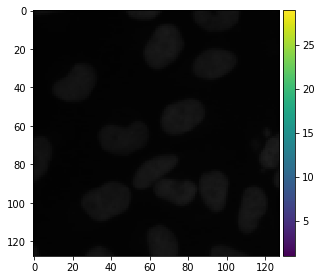

TypeError: ignored

In [ ]:
ind = random.randint(0, len(train_ids))
imshow(X_train[ind])
plt.show()
imshow(Y_train[ind])
plt.show()

In [ ]:
inputs = Input((IMG_WIDTH, IMG_HEIGHT, IMG_CHANNELS))
#we require inputs to the conv network to be floating points.
s = Lambda(lambda x:x/255)(inputs)

In [ ]:
##CALLBACKS
### Model Checkpoints
checkpointer = ModelCheckpoint('model_for_nuclei.h5', verbose = 1, save_best_only = True)
###Using Multiple callbacks
callbacks = [
             EarlyStopping(patience = 2, monitor = 'val_loss'),
             TensorBoard(log_dir = 'logs')
            ]

In [ ]:
## Unet Model
#Contraction Path
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(s)
#kernel_initializer is initial weight. he_normal is a gaussian distribution truncated around zero.
c1 = Dropout(0.1)(c1)
c1 = Conv2D(16, (3,3), activation='relu', kernel_initializer = 'he_normal', padding = 'same')(c1)
#maxpooling
p1 = MaxPooling2D((2,2))(c1)


c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

#Expansive path 
u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

#Expansion Path
u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
u9 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c9)
 
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 128, 128, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
tf.test.is_built_with_cuda()
print(tf.version.VERSION)
import sys
sys.version


Num GPUs Available:  1
2.8.0


'3.7.13 (default, Mar 16 2022, 17:37:17) \n[GCC 7.5.0]'

In [ ]:
#with tf.device('/gpu:1'):
results = model.fit(X_train,Y_train, validation_split = 0.1, batch_size = 4, epochs = 25, callbacks = callbacks)

Epoch 1/25
151/151 [==============================] - 21s 51ms/step - loss: 0.3567 - accuracy: 0.8525 - val_loss: 0.2063 - val_accuracy: 0.9153
Epoch 2/25
151/151 [==============================] - 6s 42ms/step - loss: 0.1481 - accuracy: 0.9434 - val_loss: 0.1577 - val_accuracy: 0.9375
Epoch 3/25
151/151 [==============================] - 6s 43ms/step - loss: 0.1243 - accuracy: 0.9530 - val_loss: 0.1195 - val_accuracy: 0.9545
Epoch 4/25
151/151 [==============================] - 6s 43ms/step - loss: 0.1067 - accuracy: 0.9602 - val_loss: 0.1101 - val_accuracy: 0.9580
Epoch 5/25
151/151 [==============================] - 6s 42ms/step - loss: 0.0988 - accuracy: 0.9628 - val_loss: 0.1069 - val_accuracy: 0.9588
Epoch 6/25
151/151 [==============================] - 6s 42ms/step - loss: 0.0954 - accuracy: 0.9640 - val_loss: 0.1439 - val_accuracy: 0.9493
Epoch 7/25
151/151 [==============================] - 7s 43ms/step - loss: 0.0969 - accuracy: 0.9635 - val_loss: 0.0971 - val_accuracy: 0.963

In [ ]:
Y_train

array([[[[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [ True],
         [False],
         [False]],

        ...,

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]]],


       [[[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [False]],

        [[False],
         [False],
         [False],
         ...,
         [False],
         [False],
         [Fa

In [ ]:
!conda list t.*flow

# packages in environment at C:\Users\dhany\anaconda3:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       mkl    anaconda
tensorflow                2.3.0           mkl_py38h37f7ee5_0  
tensorflow-base           2.3.0           eigen_py38h75a453f_0  
tensorflow-datasets       4.4.0                    pypi_0    pypi
tensorflow-estimator      2.3.0              pyheb71bc4_0    anaconda
tensorflow-metadata       1.5.0                    pypi_0    pypi
tensorflow-object-detection-api 0.1.1                    pypi_0    pypi


In [ ]:

idx = random.randint(0, len(X_train))


preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

 
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)


from PIL import Image
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
img1 = Image.fromarray(X_train[ix])

img2 = Image.fromarray(np.squeeze(Y_train[ix]))

img3 = Image.fromarray(np.squeeze(preds_train_t[ix]))


from PIL import Image
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
img4 = Image.fromarray(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
img6 = Image.fromarray(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))

img5 = Image.fromarray(np.squeeze(preds_val_t[ix]))
plt.show()



21/21 [==============================] - 1s 54ms/step


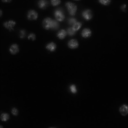

In [ ]:
img1

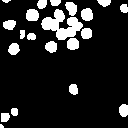

In [ ]:
img2

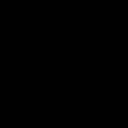

In [ ]:
img3

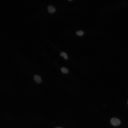

In [ ]:
img4

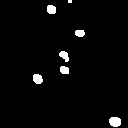

In [ ]:
img6

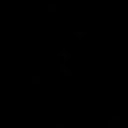

In [ ]:
img5